[(60000, 784), (60000, 10), (10000, 784), (10000, 10)]


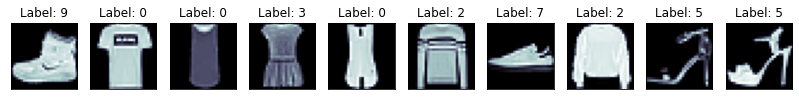

In [1]:
# Download Fashion MNIST Dataset
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './data/' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()
print([x.shape for x in [train_images, train_labels, test_images, test_labels]])

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])



# Model: Neural Network

### Overview

> For the latest updates, see the [ReadMe](readme.md).

Neural network with a variable number of hidden layers, neurons, and various training hyperparameters.

Training (`fit` method) attribute tables and progress graphs during training depending on `verbosity`. After training, "summary" stats are written to `.csv` format by default.

Later hyperparameter tuning is done with the `hyperopt` library.

Attribute | Value | Notes
:-- | :-- | :--
Hidden layer activations | ReLU | i.e. Rectified Linear Unit. $$ReLU(x) = max(0,x)$$
Output activation | Softmax | 
Loss metric | Categorical cross-entropy
Gradient descent update rule | Adam | i.e. Adaptive Movement Estimation
Overfitting prevention | Dropout | Dropout rates can be manual or ranged and reshuffled (see `fit` function)

Weights are stored as member variables via matrices.

## Initialization
### General structure
Parameter | Meaning | Fashion MNIST Value
:-- | :-- | --:
`inputs` | Number of input features | `784`
`outputs` | Number of outputs (predictions) | `10`

### Hidden neurons: shaped or manual

Number of hidden layers & height (number of neurons) at each layer will be determined by the  parameters `manual_heights`, `h_layers`, `shape`, `max_height`, and `shrink_factor`.

The hidden layers will either be manually structured or "shaped" (discussed below).

Manual: If `manual_heights` is not `None`, the number of hidden neurons at each layer will be entries in the list `manual_heights`, and the other hidden-neuron-related parameters are _ignored_.

Shaped: Otherwise, the number of hidden neurons at each layer will be generated according to a "shape":

`shape` can take one of three possible values:

Shape | Meaning
:-- | :--
`'flat'` | All hidden layers have the same number of hidden neurons
`'contracting'` | Hidden layers will linearly _decrease_ in height from left to right, with the first hidden layer having `max_height` neurons and the last layer having `(max_height)(shrink_factor)` neurons
`'expanding'` | Same structure as `'contracting'`, except from right to left (i.e. the last hidden layer is the tallest)

The number of hidden layers will be `h_layers`, and exact heights will be generated by `np.linspace`.

For example, `h_layers=3`, `shape='contracting'`, `max_height=500`, `shrink_factor=0.5` will generate a heights list of `[500,375,250]`.

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time, os
from IPython.display import clear_output
import bz2
import _pickle as cPickle

class NeuralNetwork():
    '''See markdown above for details.'''

    '''Generate list of hidden layer heights if requested'''
    def shaped_heights(self, h_layers, shape, max_height, shrink_factor):
        min, max = max_height*shrink_factor, max_height
        # The heights of the leftmost and rightmost hidden layer
        # Order according to shape
        left_right_by_shape = dict(
            flat        = (max, max),
            contracting = (max, min),
            expanding   = (min, max),
        )
        try:
            left, right = left_right_by_shape[shape]
        except KeyError:
            print(f'Invalid shape.  Must be one of: {list(left_right_by_shape.keys())}')

        heights = np.linspace(left, right, num=h_layers, dtype='int')
        assert 0 not in heights, 'Height of zero not allowed'
        self.heights_descrip = f'{shape}, ({int(left)} => {int(right)})'
        return heights

    def __init__(
        # General structure
        self, inputs, outputs,
        # Hidden-neuron-related
        manual_heights = None,
        h_layers       = 3,
        shape          = 'contracting',
        max_height     = 200,
        shrink_factor  = 0.5,
    ):
        '''Initialize heights, weights, and other member variables.
        See markdown above for details.'''
        self.heights  = None
        self.heights_descrip = None # for saving summary
    
        if manual_heights:
            self.heights = manual_heights
            self.heights_descrip = f'manual: {manual_heights}'
        else:
            assert shrink_factor > 0 and shrink_factor <= 1, 'Shrink factor must be between 0 and 1'
            # Since `hyperopt.quniform` returns floats
            h_layers, max_height = int(h_layers), int(max_height)
            self.heights  = self.shaped_heights(h_layers, shape, max_height, shrink_factor)

        self.h_layers   = len(self.heights)
        self.w_layers   = self.h_layers+1
        '''Note: Read/write operations involving weights will generally use indices
        rather than appending values to a list to help prevent improper access.'''
        self.weights    = [None] * self.w_layers
        '''Since all hidden activations are ReLU,
        initialize weights with the `he initialization` method,
        i.e. with a normal distribution centered at zero,
        with standard deviation of sqrt(2/inputs).'''
        # Weights connecting inputs -> first hidden layer
        self.weights[0] = np.random.normal(
            loc = 0,
            scale = np.sqrt(2/inputs),
            # Store biases as an extra row, since
            # z_0 = (w_0)(X), where X is a row vector for each example
            size = (inputs + 1, self.heights[0])
        )
        # Weights between hidden layers
        for i in range(1, self.h_layers):
            self.weights[i] = np.random.normal(
                0, np.sqrt(2/inputs),
                size = (self.heights[i-1]+1, self.heights[i])
            )
        # Weights connecting last hidden layer -> output
        # Store biases in an extra row, since
        # y_pred = (w_last)(h)
        self.weights[-1] = np.random.normal(
            0, np.sqrt(2/inputs),
            size = (self.heights[-1]+1, outputs)
        )

        self.epoch_performance = None
        self.epoch_weights = []
        self.epoch_weight_stats = []

        # Adam params
        self.adam_params = dict(
            lr      = 3e-4,
            b1      = 1-1e-1,
            b2      = 1-1e-3,
            epsl    = 1e-8,
        )

        self.adam_t     = 1
        self.mov_mean   = [0] * self.w_layers
        self.mov_var    = [0] * self.w_layers

    def shuffle_Xy(self, X ,y):
        '''Reshuffle X and y by randomly permuting their indices.  Maintain shape.'''
        shuffled_indices = np.random.permutation(X.shape[0])
        return X[shuffled_indices], y[shuffled_indices]

    def pad_col(self, m):
        '''Pad a column of ones to a numpy array.
        Used for calculations involving biases.'''
        ones_col = np.ones((m.shape[0], 1))
        return np.hstack([m, ones_col])

    def gradients(self, X, y_true):
        '''Forward- and backpropogate, returning
        gradients of loss with respect to weights
        for each weight layer.'''

        # Reshuffle weights according to markdown above
        if self.keep_rates_reshuffle:
            if self.keep_rates_range:
                min, max = self.keep_rates_range
                self.keep_rates = [np.random.uniform(min, max) for _ in range(self.w_layers)]
            if self.keep_rates_manual:
                np.random.shuffle(self.keep_rates_manual)

        y_pred, hs, zs = self.predict(X, self.keep_rates)
        
        gradients = [None] * self.w_layers

        # For softmax output activation,
        # dL/dw_last = (y_pred - y_true)(h)
        dL_dz = y_pred - y_true
        gradients[-1] = self.pad_col(hs[-1]).T @ dL_dz

        relu_grad = lambda m: m > 0

        # Backpropogation bewteen hidden layers
        for i in np.arange(self.w_layers-2, -1, -1):
            w_no_bias = self.weights[i+1][:-1,:]
            dL_dz = (dL_dz @ w_no_bias.T) * relu_grad(zs[i])
            # If reached last backprop (to input layer)
            prev_activations = X if i==0 else hs[i-1]
            gradients[i] = self.pad_col(prev_activations).T @ dL_dz

        # Average gradients by dividing by batch size
        return [g / X.shape[0] for g in gradients]

    def train_mini_batch(self, X, y):
        '''Forward- and back-propogate, adjusting weights via gradients
        and at magnitude via Adam algorithm.'''
        # Unpack adam params
        lr, b1, b2, epsl = [
            self.adam_params[key] for key in ['lr', 'b1', 'b2', 'epsl']
        ]

        gradients = self.gradients(X, y)

        for i in range(self.w_layers):
            # Access previous moving mean & variance and replace them with current.
            self.mov_mean[i]    = b1 * self.mov_mean[i] + (1-b1) * gradients[i]
            self.mov_var[i]     = b2 * self.mov_var[i] + (1-b2) * (gradients[i]**2)
            m_hat = self.mov_mean[i] / (1 - b1**self.adam_t)
            v_hat = self.mov_var[i] / (1 - b2**self.adam_t)

            # Update weights
            step = lr * m_hat / (np.sqrt(v_hat) + epsl)
            self.weights[i] -= step
            self.adam_t += 1

    def train_epoch(self, X, y, batch_size):
        '''Train all mini batches, until the model has been trained
        on all traning examples.  Forward- and backpropogate,
        updating weights after each mini batch.'''
        # Reshuffle training data
        X, y = self.shuffle_Xy(X, y)
        # Train mini batches until the end of the dataset is reached
        num_batches = np.ceil(X.shape[0] / batch_size) # ceil in case batch_size > num_rows
        batches_X = np.array_split(X, num_batches)
        batches_y = np.array_split(y, num_batches)

        print(f'Training epoch {self.epoch_index}:')
        iter = tqdm(zip(batches_X, batches_y), total = len(batches_X)) \
            if self.verbose else zip(batches_X, batches_y)
        for b_X, b_y in iter:
            self.train_mini_batch(b_X, b_y)

    def loss_acc(self, y_true, y_pred, as_list=False):
        '''Compute categorical cross-entropy loss and accuracy.'''

        '''From Linear Models lecture slides, categorical cross-entropy loss
            = - sum(y_true * log(y_pred))
        For y_pred, mask zero values to avoid error from log function.
        Fill values with zero, so log(0) => 0'''
        log_mask_zero = lambda m: (
            np.ma.log(
                np.ma.array(
                    m,
                    mask = m <= 0,
                    fill_value = 0
                )
            ).data
        )
        y_pred_log = log_mask_zero(y_pred)

        classif_is_correct = lambda true, pred: int(
            np.argmax(true) == np.argmax(pred)
        )

        # Calculate loss and right/wrong for each example
        losses, correct_classifs = [], []
        for true, pred, pred_log in zip(y_true, y_pred, y_pred_log):
            losses.append(-1 * np.dot(true, pred_log))
            correct_classifs.append(classif_is_correct(true, pred))

        # Return list or average per `as_list`
        result = (losses, correct_classifs) if as_list \
            else (np.average(losses), np.average(correct_classifs))

        return result

    def predict(self, X, keep_rates=None):
        '''
        Generate predictions based on input features.
        
        Returns:
            One row for each example, with probabilities for each label.
            If performing dropout (i.e. if keep_rates was passed):
                 also return neuron values
                `hs` (pre-activation) and `zs` (post-activation),
                with one column for each example.
        '''

        hs = [None] * self.h_layers
        zs = [None] * self.h_layers
        # Regularize dropout by dividing activations by keep_rate,
        # i.e. activations grow inversely to keep_rate
        dropout = lambda m, keep_rate: (
            # Use binomial distribution to determine which neurons are dropped
            m / keep_rate * np.random.binomial(
                1, keep_rate, m.shape
            )
        )
        # Activate each neuron with ReLU,
        # returning max of z_hid and 0
        relu = lambda x: np.maximum(0, x)

        if keep_rates:
            X = dropout(X, keep_rates[0])

        # Pad a column of ones for multiplication with
        # the bias entry of the weight matrix
        X_p = self.pad_col(X)

        # Unactivated neuron values:
        # z_0 = (X)(w_0)
        zs[0] = X_p @ self.weights[0]
        hs[0] = relu(zs[0])

        for i in range(1, self.h_layers):
            # Unactivated output values:
            # z[i] = (h[i-1])(w[i]); pad h for bias
            h_p = self.pad_col(hs[i-1])
            if keep_rates:
                h_p = dropout(h_p, keep_rates[i]) 
            zs[i] = h_p @ self.weights[i]
            hs[i] = relu(zs[i])
            
        # Apply softmax activation to each example,
        # normalized to prevent overflow
        softmax_normalized = lambda z: (
            np.exp(z - np.amax(z)) / np.sum(np.exp(z - np.amax(z)))
        )

        z_last = self.pad_col(hs[-1]) @ self.weights[-1]

        # Activate outputs with normed softmax function from above
        y_pred = np.apply_along_axis(
            softmax_normalized,
            axis = 1, 
            arr = z_last
        )
        result = (y_pred, hs, zs) if keep_rates else y_pred

        return result

    def evaluate(self, X, y, val):
        '''Calculate loss and accuracy based on predictions.
        Called between epochs to assess progress'''

        type = 'validation' if val else 'training'
        print(f'Evaluating {type} data for epoch {self.epoch_index}...')
        
        y_pred = self.predict(X)
        
        return self.loss_acc(y, y_pred)

    def middle_percentile_and_range(self, arr, percentile):
        '''Percentile strings used for weight distribution analysis.'''
        min, max = np.percentile(arr, [50-percentile/2, 50+percentile/2])
        range = max - min
        return f'({range:<8.4f}: {min:<8.4f} => {max:>8.4f})'

    def df_add_dict(self, df, dict_new, idx):
        '''Append a dict as a new row in a dataframe.'''
        df_new = pd.DataFrame(dict_new, index=[idx])
        # Concat to current df if passed; otherwise, return new df
        return pd.concat([df, df_new]) if type(df)==pd.core.frame.DataFrame else df_new
        
    def eval_epoch(self, X, y, x_val, y_val, start_time):
        '''Calculate loss and accuracy for training and validation sets;
        append epoch-wise stats for later saving and progress priting
        '''

        # Current epoch performance stats
        curr_loss_train, curr_acc_train = self.evaluate(X,     y,     val=False)
        curr_loss_val,   curr_acc_val   = self.evaluate(x_val, y_val, val=True)
        curr_elapsed                    = np.round(time.time() - start_time, 2)
        curr_performance = dict(
            loss_train  = curr_loss_train,
            loss_val    = curr_loss_val,
            acc_train   = curr_acc_train,
            acc_val     = curr_acc_val,
            total_sec_elapsed = curr_elapsed
        )
        assert None not in [curr_performance.values()], 'Performance values incomplete'
        
        # Append to df of epoch-wise performance stats
        self.epoch_performance = self.df_add_dict(
            self.epoch_performance, curr_performance, self.epoch_index
        )

        # Calculate values at the percentiles of weights for each layer
        # Only accessed if verbosity >= 2
        weight_stats_keys = ['all', '99p', '95p', '50p']
        percentiles = [100, 99, 95, 50]
        curr_ws = {
            key: ([None] * self.w_layers) for key in weight_stats_keys
        }
        for i in range(self.w_layers):
            for key, percentile in zip(weight_stats_keys, percentiles):
                curr_ws[key][i] = self.middle_percentile_and_range(
                    self.weights[i], percentile
                )
        # Replace weight stats with current epoch's weight stats
        self.epoch_weight_stats = pd.DataFrame(
            curr_ws, index=[i for i in range(self.w_layers)]
        ).style.set_properties(**{'white-space': 'pre'})

    def label_plt(self, title, xlab, ylab):
        '''Shorthand for plot labels.'''
        plt.rcParams['font.size'] = 16
        plt.title(title)
        plt.xlabel(xlab)
        plt.ylabel(ylab)

    def print_progress(self):
        '''Print progress to console depending on `self.verbose`.
        Output is cleared each epoch, so any persistent data
        must be appended to `print_cache`.'''
        clear_output()
        for line in self.print_cache:
            if type(line) == pd.core.frame.DataFrame:
                display(line)
            if type(line) == str:
                print(line)
        print('Performance By Epoch:')
        display(pd.DataFrame(self.epoch_performance))
        
        # Graphs for epoch-wise progress
        if self.epoch_index > 0:
            plt.figure(figsize=(16,6))

            min_epoch = np.maximum(0, self.epoch_index-5)
            epochs    = range(min_epoch, self.epoch_index+1)
            ep        = self.epoch_performance[min_epoch:self.epoch_index+1]

            # Loss and miss rate (1-accuracy) for each epoch.
            misses_train = 1-ep.acc_train
            misses_val   = 1-ep.acc_val 
            plt.plot(epochs, ep.loss_train,  label='Loss: Training',   c='b', linestyle='--')
            plt.plot(epochs, ep.loss_val,    label='Loss: Validation', c='b')
            plt.plot(epochs, 1-ep.acc_train, label='Misclassif Rate: Training',   c='r', linestyle='--')
            plt.plot(epochs, 1-ep.acc_val,   label='Misclassif Rate: Validation', c='r')
            plt.legend(loc='upper left')
            plt.ylim(0, 1.05*ep.loss_val[min_epoch+1])
            plt.xticks(epochs)
            self.label_plt('Loss and Misclassification Rate vs. Epoch', 'After Epoch', 'Value')
            plt.show()
        
            '''Overfitting ratios: validation/training 
            for stats attempting to be minimized.
            Thus, the higher the ratio, the higher the implied overfitting.
            Dropout keeps this ratio low but, but the model
            tends to underfit when keep_rate is low.'''
            plt.figure(figsize=(16,3))
            ovf_ratio_loss   = ep.loss_val/ep.loss_train
            ovf_ratio_misses = misses_val/misses_train
            plt.plot(epochs, ovf_ratio_loss,   label='Loss',               c='b', linestyle='dotted')
            plt.plot(epochs, ovf_ratio_misses, label='Misclassif Rate', c='r', linestyle='dotted')
            plt.legend(loc='upper left')
            max_ratio = np.amax([ovf_ratio_loss, ovf_ratio_misses])
            for i in np.arange(1, max_ratio, 0.05):
                plt.axhline(y=i, c='gray', linestyle='dotted', alpha=0.5)
            # Find good window for ratios
            plt.ylim(1, 1.01*max_ratio)
            plt.xticks(epochs)
            self.label_plt('Overfitting Ratios vs. Epoch', 'After Epoch', 'Validation to Training Ratio')            
            plt.show()

        if self.verbose >= 2:
            print(f'Weight Percentiles after Epoch {self.epoch_index}:')
            print('Percentiles formatted as "(Range: Min => Max)"')
            display(self.epoch_weight_stats)

    def p_save(self, obj, path):
        '''Compress and write any object to file.'''
        with bz2.BZ2File(f'{path}.pbz2', 'w') as f:
            cPickle.dump(obj, f)

    def p_load(self, path):
        '''Read and unzip and .pbz2 object.'''
        data = bz2.BZ2File(f'{path}.pbz2', 'rb')
        data = cPickle.load(data)
        return data            

    def save_summary(self, store_large=False):
        '''Write key stats to file, primarily .csv format.
        Weight matrices for `min_loss` and `max_acc` can be saved using
        `store_large`, but file sizes are quite large, even when compressed.'''
        # Unique ID for model
        id = hash(time.time())
        folder = f'trained_models/{id}'
        os.mkdir(folder)

        # Store extended stats in folder for model
        self.epoch_performance.to_csv(f'{folder}/epoch_performance.csv')
        hp_df = pd.DataFrame.from_dict(self.hyperparams, orient='index', columns=['Value'])
        hp_df.index.name = 'Hyperparameter'
        hp_df.to_csv(f'{folder}/hyperparams.csv')
        if store_large:
            self.p_save(self.min_loss_weights, f'{folder}/min_loss_weights')
            self.p_save(self.max_acc_weights,  f'{folder}/max_acc_weights')
        
        # Append one-liner summary to summary file
        summary_df = pd.DataFrame(self.hyperparams, index=[id])
        summary_df.insert(0, 'min_loss_val', self.min_loss)
        summary_df.insert(1, 'max_acc_val',  self.max_acc)
        summary_df.insert(
            len(summary_df.columns), 'epochs_min_loss_val',
            np.argmin(self.epoch_performance.loss_val)
        )
        summary_df.insert(
            len(summary_df.columns), 'total_sec', 
            self.epoch_performance.total_sec_elapsed[self.epoch_index]
        )
        try:
            # In case `summaries.csv` not yet created
            prev_summaries = pd.read_csv('summaries.csv', index_col=0)
            all_summaries  = self.df_add_dict(prev_summaries, summary_df, id)
        except FileNotFoundError:
            all_summaries = summary_df
        # Write backup of summaries then main summaries file
        all_summaries.to_csv(f'summary_backups/after_{id}.csv')
        all_summaries.to_csv('summaries.csv')

# Training (`fit` function)

> For the latest updates, see the [ReadMe](readme.md).

## General hyperparameters
| Parameter(s) | Meaning | Type | Notes
| :-- | :-- | :-- | :--
| `X`, `y` | Training data | `np.array` | Examples stored as rows
| `x_val`, `y_val` | Validation data | `np.array` | Examples stored as rows
| `lr` | Learning rate | `float` | Fraction by which weight adjustments (i.e. negative loss gradients) are multiplied during fitting for each mini-batch to update weights
| `batch_size` | Mini-batch size | `int` | The number of examples trained simultaneously before weights are adjusted


## Dropout: type
The model will be trained according to one either type of dropout (not both):

| Dropout type | Associated param | Type | Notes
| :-- | :-- | :-- | :--
| Manual | `keep_rates_manual` | `list` | One `keep_rate` for each hidden layer
| Ranged | `keep_rates_range` | `list` | `min` and `max` `keep_rate`s to be randomly set for each layer per `np.random.uniform`

## Dropout: reshuffling
`keep_rates_reshuffle` determines reshuffling status for all of training.
| Reshuffling | Dropout type | Meaning
| :-- | :-- | :--
| Yes | Manual | `keep_rates` is reordered randomly for each mini-batch
| Yes | Ranged | `keep_rates` is re-rolled per `np.random.binomial` for each mini-batch
| No  | Manual | `keep_rates` remains as passed
| No  | Ranged | `keep_rates` is not modified after instantiation at the start of training (per `np.random.binomial`)

Note: to avoid ambiguity, values are stated as `keep_rate`, i.e. the odds of a given neuron being "kept" during training.  Neurons are dropped according to a binomial distribution during training.


## Early stopping tolerance

The model incurs a "strike" when validation loss increases between epochs.  The limits, `total_strikes` and `total_strikes_consecutive`, can be specified.  If either of these conditions limits are exceeded, training stops.

In [3]:
def fit(
        # General
        self, X, y, x_val, y_val, lr=3e-4, batch_size=2**9,
        # Dropout
        keep_rates_manual=None, keep_rates_range=None, keep_rates_reshuffle=False,
        # Early stopping tolerance
        max_consec_strikes=2, max_strikes=2, max_epochs=100,
        # Progress printing
        verbose=3, print_cache=[], save_summary=True
    ):   
        '''See markdown above for hyperparameter and function details'''

        batch_size = int(batch_size)

        # Generate or store keep_rate list
        assert not(keep_rates_manual and keep_rates_range), \
            'Cannot have manual & range-based dropout'
        keep_rates_descrip = 'None' # For summary dataframe
        if keep_rates_range:
            min, max = keep_rates_range
            self.keep_rates = [np.random.uniform(min, max) for _ in range(self.w_layers)]
            keep_rates_descrip = f'range: ({min}, {max})'
        elif keep_rates_manual:
            assert len(keep_rates_manual)==self.h_layers, \
                'Uneven dropout / hidden layers'  
            self.keep_rates = keep_rates_manual
            keep_rates_descrip = f'manual: {keep_rates_manual}'
        else:
            self.keep_rates  = None
        # Accessed in prediction and gradients methods
        self.keep_rates_manual    = keep_rates_manual            
        self.keep_rates_range     = keep_rates_range
        self.keep_rates_reshuffle = keep_rates_reshuffle

        # Store relevant hyperparameters for summary dataframe
        self.hyperparams = dict(
            h_layers    = self.h_layers,
            heights     = self.heights_descrip,
            lr          = lr,
            batch_size  = batch_size,
            keep_rates  = keep_rates_descrip,
            reshuff     = keep_rates_reshuffle,
            max_strikes = max_strikes,
            max_consec  = max_consec_strikes,
        )
        # Pin the current hyperparams to the top of printing,
        # which is otherwise cleared after each epoch
        self.print_cache = print_cache
        self.print_cache.extend([
            'Training w/ hyperparams:',
            pd.DataFrame(self.hyperparams, index=[None]),
        ])
        self.adam_params['lr']  = lr
        self.verbose            = verbose
        start_time = time.time()

        # To return for hyperparameter tuning and summary dataframe
        self.min_loss         = np.inf
        self.min_loss_weights = None
        self.max_acc          = 0
        self.max_acc_weights  = None

        # Start strikes at zero
        total_strikes = 0
        consec_strikes = 0
        self.print_cache.extend([
            f"Total strikes:    0/{max_strikes}",
            f"Consec strikes:   0/{max_consec_strikes}",
        ])

        self.epoch_index = 0
        print('Pre-training evaluation:')
        self.eval_epoch(X, y, x_val, y_val, start_time)
        if self.verbose:
            self.print_progress()

        # Train until either `max_epochs` is reached or either
        # of the early stopping limits are reached
        while self.epoch_index <= max_epochs:
            self.epoch_index += 1

            self.train_epoch(X, y, batch_size)
            self.eval_epoch(X, y, x_val, y_val, start_time)

            # Access previous 2 losses and accuracies
            # for validation data
            prev_loss_val, curr_loss_val = \
                self.epoch_performance.loss_val[-2:]
            prev_acc_val, curr_acc_val = \
                self.epoch_performance.acc_val[-2:]

            # Update best stats if applicable
            if curr_loss_val < self.min_loss:
                self.min_loss = curr_loss_val
                self.min_loss_weights = np.copy(self.weights)
            if curr_acc_val > self.max_acc:
                self.max_acc = curr_acc_val
                self.max_acc_weights = np.copy(self.weights)

            # If starting to overfit
            if curr_loss_val > prev_loss_val:
                total_strikes   += 1
                consec_strikes  += 1
            else:
                consec_strikes = 0
            
            # Replace the last 2 lines of `print_cache` with the current strikes,
            self.print_cache[-2:] = [
                    f"Total strikes:    {total_strikes}/{max_strikes}",
                    f"Consec strikes:   {consec_strikes}/{max_consec_strikes}",
                ]
        
            if self.verbose:
                self.print_progress()

            # Early stopping: if total or consecutive allowed strikes
            # have been exceeded, stop training
            if (consec_strikes >= max_consec_strikes) \
                    or (total_strikes >= max_strikes):
                print(f'Stopped training after epoch {self.epoch_index}')
                if save_summary:
                    self.save_summary()
                return self.min_loss
        
        # By now, `max_epochs` has been reached
        print(f'Reached max epoch of {self.epoch_index}')

        # Write summary stats to file by default
        if save_summary:
            self.save_summary()
            
        # Return best loss value for hyperparameter tuning
        return self.min_loss
NeuralNetwork.fit = fit

# Hyperparameter tuning

[Hyperopt](https://github.com/hyperopt/hyperopt) optimizes hyperparameters within a search space based on previous trials.

Here, the [Tree Parzen Estimator](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) uses [Bayesian principles](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f#:~:text=The%20Tree%20Parzen%20Estimator%20is,will%20explore%20in%20further%20articles.) to adjust hyperparameters between calls to `NeuralNetwork.fit`.

The search space includes initialization and training parameters.

Referenced [hyperopt article](https://towardsdatascience.com/optimise-your-hyperparameter-tuning-with-hyperopt-861573239eb5).

Most recent 5 models:                                                               
  6%|▌         | 3/50 [30:57<6:24:58, 491.45s/trial, best loss: 0.29682004879475027]

,min_loss_val,max_acc_val,h_layers,heights,lr,batch_size,keep_rates,reshuff,max_strikes,max_consec,epochs_min_loss_val,total_sec
1.569866e+18,0.347102,0.8728,5,"expanding, (779 => 1027)",0.000878,2567,"range: (0.743697755047109, 1)",True,2,2,8,228.43
2.010303e+18,0.875556,0.6422,12,"contracting, (545 => 303.93009374166417)",0.000649,9074,"range: (0.9986011833332963, 1)",True,2,2,4,105.49
1.506822e+18,0.353574,0.8717,7,"contracting, (1152 => 965)",0.000387,7891,"range: (0.9880689767730996, 1)",True,2,2,8,373.70
1.553061e+18,0.296820,0.8948,3,"flat, (1868 => 1868)",0.000727,1680,"range: (0.9355129444418089, 1)",True,2,2,9,411.99
5.859561e+17,0.317162,0.8893,2,"flat, (2217 => 2217)",0.000958,8384,"range: (0.9574205412071565, 1)",False,2,2,19,602.75


Training w/ hyperparams:                                                            
  6%|▌         | 3/50 [30:57<6:24:58, 491.45s/trial, best loss: 0.29682004879475027]

,h_layers,heights,lr,batch_size,keep_rates,reshuff,max_strikes,max_consec
None,6,"flat, (1722 => 1722)",0.000295,6177,"range: (0.9063534362914952, 1)",True,2,2


Total strikes:    0/2                                                               
Consec strikes:   0/2                                                               
Performance By Epoch:                                                               
  6%|▌         | 3/50 [30:57<6:24:58, 491.45s/trial, best loss: 0.29682004879475027]

,loss_train,loss_val,acc_train,acc_val,total_sec_elapsed
0,16.285726,16.294669,0.089950,0.0903,24.15
1,2.333233,2.385852,0.481400,0.4769,97.18
2,0.717084,0.739928,0.739100,0.7330,169.38
3,0.538120,0.559666,0.810983,0.8031,243.47
4,0.467057,0.493848,0.835633,0.8250,317.26
5,0.418482,0.451060,0.853267,0.8404,390.96
6,0.385921,0.421286,0.861133,0.8501,464.86


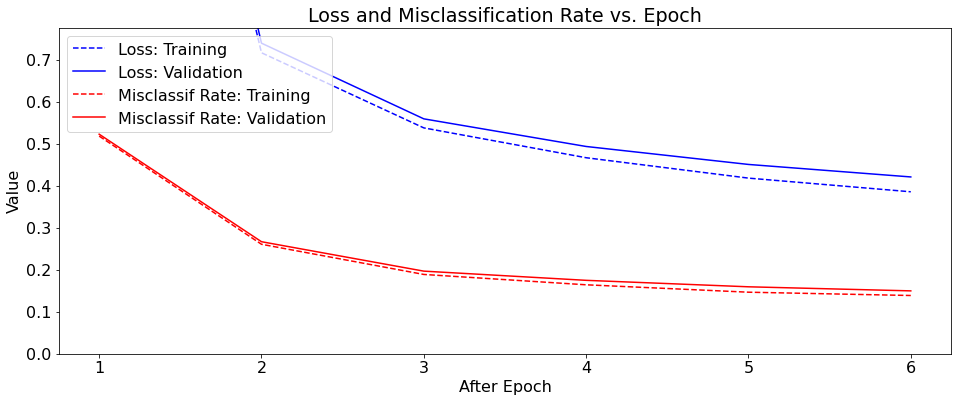

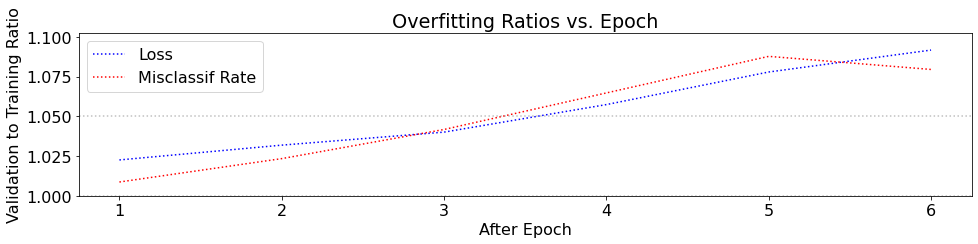

Weight Percentiles after Epoch 6:                                                   
Percentiles formatted as "(Range: Min => Max)"                                      
  6%|▌         | 3/50 [30:57<6:24:58, 491.45s/trial, best loss: 0.29682004879475027]

,all,99p,95p,50p
0,(0.4953 : -0.2541 => 0.2412),(0.2600 : -0.1312 => 0.1288),(0.1982 : -0.1001 => 0.0981),(0.0682 : -0.0350 => 0.0332)
1,(0.5250 : -0.2608 => 0.2641),(0.2606 : -0.1314 => 0.1292),(0.1983 : -0.1002 => 0.0980),(0.0683 : -0.0353 => 0.0330)
2,(0.5174 : -0.2566 => 0.2608),(0.2603 : -0.1311 => 0.1292),(0.1982 : -0.1002 => 0.0980),(0.0683 : -0.0351 => 0.0332)
3,(0.5116 : -0.2516 => 0.2600),(0.2605 : -0.1311 => 0.1294),(0.1981 : -0.0999 => 0.0982),(0.0682 : -0.0351 => 0.0331)
4,(0.5258 : -0.2769 => 0.2489),(0.2605 : -0.1312 => 0.1293),(0.1982 : -0.1002 => 0.0980),(0.0682 : -0.0352 => 0.0330)
5,(0.5182 : -0.2604 => 0.2578),(0.2602 : -0.1310 => 0.1292),(0.1982 : -0.0998 => 0.0984),(0.0683 : -0.0348 => 0.0335)
6,(0.3976 : -0.2029 => 0.1946),(0.2604 : -0.1302 => 0.1302),(0.1972 : -0.0988 => 0.0983),(0.0673 : -0.0334 => 0.0340)


Training epoch 7:                                                                   
  6%|▌         | 3/50 [30:57<6:24:58, 491.45s/trial, best loss: 0.29682004879475027]

 60%|######    | 6/10 [00:29<00:19,  5.00s/it]


In [4]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK

# Define ranges for hyperopt to search
search_space = dict(
    # Init params
    h_layers      = hp.quniform('h_layers',     1,15,1),
    shape         = hp.choice('shape',          ['flat', 'contracting', 'expanding']),
    max_height    = hp.quniform('max_height',   20,2500,1),
    shrink_factor = hp.uniform('shrink_factor', 0.5,1),
    # Training params
    batch_size           = hp.quniform('batch_size',        6, 10000,1),
    lr                   = hp.uniform('lr',                 1e-4, 1e-3),
    keep_rates_min       = hp.uniform('keep_rates_min',     0.9,1), # Best seem to be >= 0.9
    keep_rates_reshuffle = hp.choice('keep_rates_reshuffle',[True,False]),
)

# If desired, specify starting points for hyperparams
# via https://gist.github.com/jaikumarm/bca0e895ca19267d14d6ade194394191

def objective(search_space):
    # Initialize
    model = NeuralNetwork(
        inputs         = train_images.shape[1],
        outputs        = train_labels.shape[1],
        **{
            key: search_space[key] for key in [
                'h_layers', 'shape', 'max_height', 'shrink_factor',
            ]
        }   
    )

    # Pin the most recent models to the top        
    most_recent  = 5
    summaries_df = pd.read_csv('summaries.csv', index_col=0)
    summaries_print = summaries_df if summaries_df.shape[0] < most_recent \
        else summaries_df.iloc[summaries_df.shape[0]-most_recent:]

    # Fit and return best loss value
    loss = model.fit(
        X       = train_images,
        y       = train_labels,
        x_val   = test_images,
        y_val   = test_labels,
        # By default, allow keep_rates_range to go up to 1
        keep_rates_range = [search_space['keep_rates_min'], 1],
        **{
            key: search_space[key] for key in [
                'batch_size', 'lr', 'keep_rates_reshuffle'
            ]
        },
        print_cache  = [f'Most recent {most_recent} models:', summaries_print]

    )
    return dict(
        loss   = loss,
        status = STATUS_OK
    )

# Optimize hyperparameters via loss function, search space,
# and Tree Parzen Estimators, while saving summaries for each model
best = fmin(
    fn        = objective,
    space     = search_space,
    algo      = tpe.suggest,
    max_evals = 50
)